In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy


Following the model developed in Roy and Moharir - 2019 - Modeling the Generic Breakthrough Curve for Adsorption Process
Modified the LDF values by decreasing by a factor of 10 to accurately replicate the results.

The following equations are in the form of a PDE with partial derivatives in time (dt) and space (dz). The problem was simplified into a solveable system of ODEs by discretizing dz using the finite difference method. 

The boundary condition at the end of the membrane (z=z) was approximated using the backwards second order difference method that utilizes taylor series expansion to estimate the derivative at the boundary using an average of the preceding two points. 

The derivative dC/dz in the function is approximated using the central difference scheme by considering concentration values at neighboring points. This scheme ensures that the rate of change is approximated using information from both sides of the point, leading to a more accurate representation of the spatial variation.

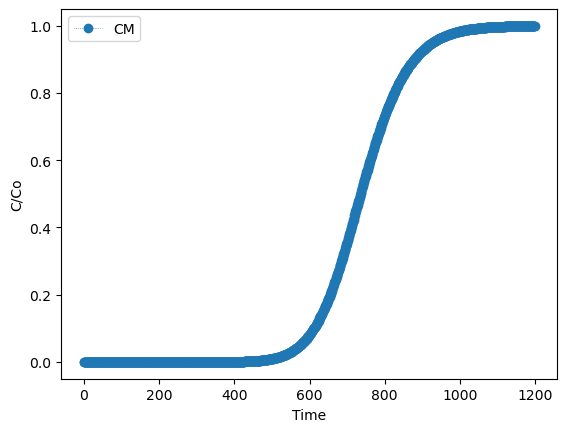

In [3]:
# Input data
# Roy and Moharir - 2019 - Modeling the Generic Breakthrough Curve for Adsorption Process
eps = 0.4  # porosity  
u = 0.01  # [m/s] chosen flow velocity 
LDF1 = 0.05 # sec-1
b1 = 0.3 # m3/kg
qm1 = 0.04 # kg adsorbed/kg adsorbent
c1o = 1 # kg/m3
rhop = 1000  # [kg/m3] density of the polymer substrate units

Qe1 = qm1*b1*c1o/(1+b1*c1o)

# Increment for Length
L = 0.5  # [m] thickness of membrane
Nz = 101  # number of steps for thickness
z = np.linspace(0, L, Nz)  # generate a list filled with 11 equally spaced steps of thicknesses from 0 to L
dz = z[1] - z[0]  # [m] step size

# Time
t = np.arange(0, 1200, 1)  # [sec] 

# Initial conditions
IC1a = np.zeros(Nz) # PDE
IC1b = np.zeros(Nz) # ODE
IC = np.concatenate((IC1a, IC1b))

# Function for the ODE
def f(t, y):
    dCMdt = np.zeros(Nz)
    dQtdt = np.zeros(Nz)

    # Define values
    CM = y[:Nz]
    Qt = y[Nz:]


    # Boundary conditions
    CM[0] = c1o # at z=0, the initial concentration of the feed is c1o
    CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error

    # Interior
    for i in range(1, Nz - 1):  # material balance between solid adsorbent and liquid feed
        # list of relevant assumptions referenced in Roy and Moharir
        dQtdt[i] = LDF1*((qm1*b1*CM[i]/(1+b1*CM[i])) - Qt[i])
        dCMdz = (CM[i + 1] - CM[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed
        dCMdt[i] = -u * dCMdz - rhop * ((1 - eps) / eps) * dQtdt[i]  # amount in the liquid

    return np.concatenate((dCMdt, dQtdt))

# Solve ODE
sol = solve_ivp(fun=f, t_span=(min(t), max(t)), y0=IC, t_eval=t, method='RK45') # method='RK45'

# Extract results
CM = sol.y[:Nz].T  # solution is time points x depths into the membrane thickness
Qt = sol.y[Nz:].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness

# Reinput BC
CM[0] = 0 # at t=0, the initial concentration the outlet concentration is 0
CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error

# Plot breakthrough curves
fig, ax = plt.subplots()
cend = CM[:, -1]  # get the outlet concentration at the full thickness of the membrane
cplot = cend / c1o  # make the outlet concentration a dimensionless form of the original concentration
ax.plot(sol.t, cplot, linestyle=":", linewidth=0.5, marker='o', markersize=6, label='CM')

ax.set_xlabel('Time')
ax.set_ylabel('C/Co')
ax.legend()

plt.show()

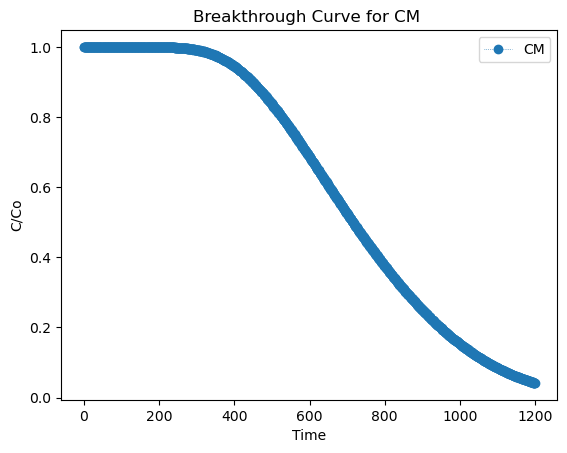

In [30]:
# Input data
# Roy and Moharir - 2019 - Modeling the Generic Breakthrough Curve for Adsorption Process
eps = 0.4  # porosity  
u = 0.01  # [m/s] chosen flow velocity 
LDF1 = 0.05 # sec-1
b1 = 0.3 # m3/kg
qm1 = 0.04 # kg adsorbed/kg adsorbent
c1o = 1 # kg/m3
rhop = 1000  # [kg/m3] density of the polymer substrate units

Qe1 = qm1*b1*c1o/(1+b1*c1o)

# Increment for Length
L = 0.5  # [m] thickness of membrane
Nz = 101  # number of steps for thickness
z = np.linspace(0, L, Nz)  # generate a list filled with 11 equally spaced steps of thicknesses from 0 to L
dz = z[1] - z[0]  # [m] step size

# Time
t = np.arange(0, 1200, 1)  # [sec] 

# Initial conditions
IC1a = Nz*[c1o]
IC1b = Nz*[Qe1]
IC = np.concatenate((IC1a, IC1b))

# Function for the ODE
def f(t, y):
    dCMdt = np.zeros(Nz)
    dQtdt = np.zeros(Nz)

    # Define values
    CM = y[:Nz]
    Qt = y[Nz:]


    # Boundary conditions
    CM[0] = 0
    CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error

    # Interior
    for i in range(1, Nz - 1):  # material balance between solid adsorbent and liquid feed
        # list of relevant assumptions referenced in Roy and Moharir
        dQtdt[i] = LDF1*(qm1*b1*CM[i]/(1+b1*CM[i]) - Qt[i])
        dCMdz = (CM[i + 1] - CM[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed
        dCMdt[i] = -u * dCMdz - rhop * ((1 - eps) / eps) * dQtdt[i]  # amount in the liquid

    return np.concatenate((dCMdt, dQtdt))

# Solve ODE
sol = solve_ivp(fun=f, t_span=(min(t), max(t)), y0=IC, t_eval=t, method='RK45') # method='RK45'

# Extract results
CM = sol.y[:Nz].T  # solution is time points x depths into the membrane thickness
Qt = sol.y[Nz:].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness

# Reinput BC
CM[0] = c1o
Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error

# Plot breakthrough curves
fig, ax = plt.subplots()
cend = CM[:, -1]  # get the outlet concentration at the full thickness of the membrane
cplot = cend / c1o  # make the outlet concentration a dimensionless form of the original concentration
ax.plot(sol.t, cplot, linestyle=":", linewidth=0.5, marker='o', markersize=6, label='CM')

ax.set_title('Breakthrough Curve for CM ')
ax.set_xlabel('Time')
ax.set_ylabel('C/Co')
ax.legend()

plt.show()

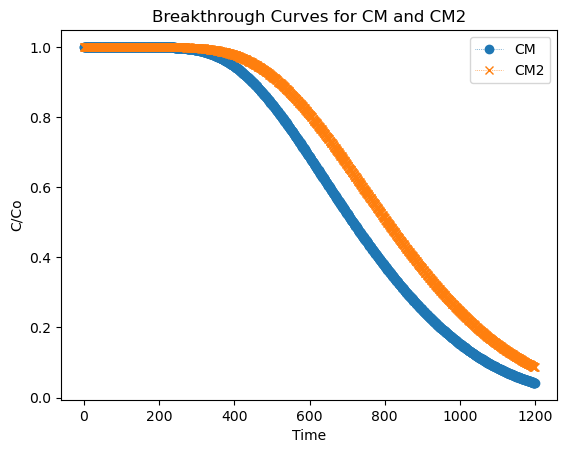

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Input data for CM
eps = 0.4  # porosity  
u = 0.01  # [m/s] chosen flow velocity 
LDF1 = 0.05  # sec-1
b1 = 0.3  # m3/kg
qm1 = 0.04  # kg adsorbed/kg adsorbent
c1o = 1  # kg/m3
rhop = 1000  # [kg/m3] density of the polymer substrate units
Qe1 = qm1 * b1 * c1o / (1 + b1 * c1o)

# Input data for CM2
LDF2 = 0.04  # sec-1
b2 = 0.25  # m3/kg
qm2 = 0.05  # kg adsorbed/kg adsorbent
c2o = 0.8  # kg/m3
Qe2 = qm2 * b2 * c2o / (1 + b2 * c2o)

# Increment for Length
L = 0.5  # [m] thickness of membrane
Nz = 101  # number of steps for thickness
z = np.linspace(0, L, Nz)  # generate a list filled with 101 equally spaced steps of thicknesses from 0 to L
dz = z[1] - z[0]  # [m] step size

# Time
t = np.arange(0, 1200, 1)  # [sec] 

# Initial conditions
IC1a = Nz * [c1o]
IC1b = Nz * [Qe1]
IC2a = Nz * [c2o]
IC2b = Nz * [Qe2]
IC = np.concatenate((IC1a, IC1b, IC2a, IC2b))

# Function for the ODE
def f(t, y):
    dCMdt = np.zeros(Nz)
    dQtdt = np.zeros(Nz)
    dCM2dt = np.zeros(Nz)
    dQt2dt = np.zeros(Nz)

    # Define values
    CM = y[:Nz]
    Qt = y[Nz:2*Nz]
    CM2 = y[2*Nz:3*Nz]
    Qt2 = y[3*Nz:]

    # Boundary conditions
    CM[0] = 0
    CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
    CM2[0] = 0
    CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error

    # Interior
    for i in range(1, Nz - 1):  # material balance between solid adsorbent and liquid feed
        # list of relevant assumptions referenced in Roy and Moharir
        dQtdt[i] = LDF1 * (qm1 * b1 * CM[i] / (1 + b1 * CM[i]) - Qt[i])
        dQt2dt[i] = LDF2 * (qm2 * b2 * CM2[i] / (1 + b2 * CM2[i]) - Qt2[i])
        
        dCMdz = (CM[i + 1] - CM[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed
        dCM2dz = (CM2[i + 1] - CM2[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed
        
        dCMdt[i] = -u * dCMdz - rhop * ((1 - eps) / eps) * dQtdt[i]  # amount in the liquid
        dCM2dt[i] = -u * dCM2dz - rhop * ((1 - eps) / eps) * dQt2dt[i]  # amount in the liquid

    return np.concatenate((dCMdt, dQtdt, dCM2dt, dQt2dt))

# Solve ODE
sol = solve_ivp(fun=f, t_span=(min(t), max(t)), y0=IC, t_eval=t, method='RK45') # method='RK45'

# Extract results
CM = sol.y[:Nz].T  # solution is time points x depths into the membrane thickness
Qt = sol.y[Nz:2*Nz].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness
CM2 = sol.y[2*Nz:3*Nz].T
Qt2 = sol.y[3*Nz:].T

# Reinput BC
CM[0] = c1o
Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error
CM2[0] = c2o
Qt2[-1] = (4 * Qt2[-2] - Qt2[-3]) / 3  # Use backward second order error

# Plot breakthrough curves
fig, ax = plt.subplots()
cend = CM[:, -1]  # get the outlet concentration at the full thickness of the membrane
cplot = cend / c1o  # make the outlet concentration a dimensionless form of the original concentration
ax.plot(sol.t, cplot, linestyle=":", linewidth=0.5, marker='o', markersize=6, label='CM')

cend2 = CM2[:, -1]  # get the outlet concentration at the full thickness of the membrane
cplot2 = cend2 / c2o  # make the outlet concentration a dimensionless form of the original concentration
ax.plot(sol.t, cplot2, linestyle=":", linewidth=0.5, marker='x', markersize=6, label='CM2')

ax.set_title('Breakthrough Curves for CM and CM2')
ax.set_xlabel('Time')
ax.set_ylabel('C/Co')
ax.legend()

plt.show()


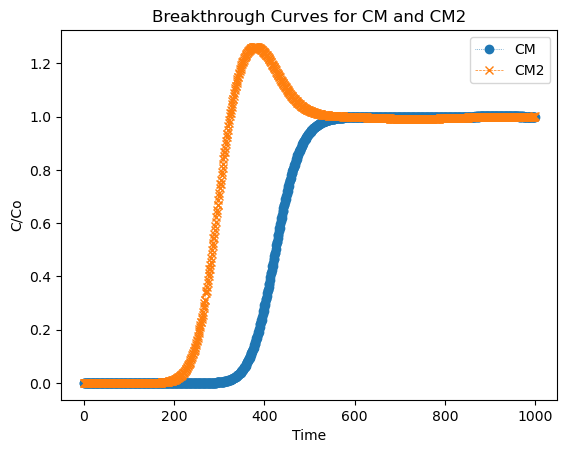

In [11]:
# Input data
# Roy and Moharir - 2019 - Modeling the Generic Breakthrough Curve for Adsorption Process
eps = 0.4  # porosity  
u = 0.01  # [m/s] chosen flow velocity 
LDF1 = 0.15 # sec-1  1.5
LDF2 = 0.15 # sec-1  1.5
# LDF1 = 1.5 # sec-1  1.5
# LDF2 = 1.5 # sec-1  1.5
b1 = 0.4 # m3/kg
b2 = 0.3 # m3/kg
qm1 = 0.04 # kg adsorbed/kg adsorbent
qm2 = 0.03 # kg adsorbed/kg adsorbent
c1o = 0.75 # kg/m3
c2o = 0.5 # kg/m3
rhop = 800  # [kg/m3] density of the polymer substrate units

# Qe1 = qm1*b1*c1o/(1+b1*c1o+b2*c2o)
# Qe2 = qm2*b2*c2o/(1+b1*c2o+b2*c2o)

# Increment for Length
L = 0.3  # [m] thickness of membrane
Nz = 51  # number of steps for thickness
z = np.linspace(0, L, Nz)  # generate a list filled with 11 equally spaced steps of thicknesses from 0 to L
dz = z[1] - z[0]  # [m] step size

# Time
t = np.arange(0, 1000, 1)  # [sec] 

# Initial conditions
IC1a = np.zeros(Nz)
IC1b = np.zeros(Nz)
IC2a = np.zeros(Nz)
IC2b = np.zeros(Nz)
IC = np.concatenate((IC1a, IC1b, IC2a, IC2b))

# Function for the ODE
def f(t, y):
    dCMdt = np.zeros(Nz)
    dQtdt = np.zeros(Nz)
    dCM2dt = np.zeros(Nz)
    dQt2dt = np.zeros(Nz)

    # Define values
    CM = y[:Nz]
    Qt = y[Nz:2*Nz]
    CM2 = y[2*Nz:3*Nz]
    Qt2 = y[3*Nz:]

    # Boundary conditions
    CM[0] = c1o
    CM2[0] = c2o
    CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
    CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error

    # Interior
    for i in range(1, Nz - 1):  # material balance between solid adsorbent and liquid feed
        # list of relevant assumptions referenced in Roy and Moharir
        dQtdt[i] = LDF1*(qm1*b1*CM[i]/(1+b1*CM[i]+b2*CM2[i]) - Qt[i])
        dQt2dt[i] = LDF2*(qm2*b2*CM2[i]/(1+b1*CM[i]+b2*CM2[i]) - Qt2[i])
        dCMdz = (CM[i + 1] - CM[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed
        dCM2dz = (CM2[i + 1] - CM2[i - 1]) / (2 * dz)  # amount in solution adsorbed to the bed for CM2
        dCMdt[i] = -u * dCMdz - rhop * ((1 - eps) / eps) * dQtdt[i]  # amount in the liquid
        dCM2dt[i] = -u * dCM2dz - rhop * ((1 - eps) / eps) * dQt2dt[i]  # amount in the liquid for CM2

    return np.concatenate((dCMdt, dQtdt, dCM2dt, dQt2dt))

# Solve ODE
sol = solve_ivp(fun=f, t_span=(min(t), max(t)), y0=IC, t_eval=t, method='RK45') # method='RK45'

# Extract results
CM = sol.y[:Nz].T  # solution is time points x depths into the membrane thickness
Qt = sol.y[Nz:2*Nz].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness
CM2 = sol.y[2*Nz:3*Nz].T  # solution is time points x depths into the membrane thickness for CM2
Qt2 = sol.y[3*Nz:].T  # Due to concatenation in the function, C and Q values are stored for each membrane thickness for CM2

# Reinput BC
CM[0] = 0
CM[-1] = (4 * CM[-2] - CM[-3]) / 3  # Use backward second order error
Qt[-1] = (4 * Qt[-2] - Qt[-3]) / 3  # Use backward second order error
CM2[0] = 0
CM2[-1] = (4 * CM2[-2] - CM2[-3]) / 3  # Use backward second order error
Qt2[-1] = (4 * Qt2[-2] - Qt2[-3]) / 3  # Use backward second order error

# Plot breakthrough curves
fig, ax = plt.subplots()
cend = CM[:, -1]  # get the outlet concentration at the full thickness of the membrane
cplot = cend / c1o  # make the outlet concentration a dimensionless form of the original concentration
ax.plot(sol.t, cplot, linestyle=":", linewidth=0.5, marker='o', markersize=6, label='CM')


cend2 = CM2[:, -1]  # get the outlet concentration at the full thickness of the membrane for CM2
cplot2 = cend2 / c2o  # make the outlet concentration a dimensionless form of the original concentration for CM2
ax.plot(sol.t, cplot2, linestyle="--", linewidth=0.5, marker='x', markersize=6, label='CM2')

ax.set_title('Breakthrough Curves for CM and CM2')
ax.set_xlabel('Time')
ax.set_ylabel('C/Co')
ax.legend()

plt.show()